In [26]:
%load_ext autoreload
%autoreload 2
%load_ext tensorboard

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
The tensorboard extension is already loaded. To reload it, use:
  %reload_ext tensorboard


In [27]:
import pandas as pd
import numpy as np
from winkie import ml
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

import seaborn as sn
import matplotlib.pyplot as plt
import datetime

import tensorflow as tf

In [28]:
df = pd.read_hdf("labelled_merged.h5")
df

bodyparts        head                               beak              \
coords              x           y likelihood           x           y   
0          716.210449  253.077591   0.999999  685.722412  249.250351   
1          716.454956  252.469467   0.999999  685.662415  249.108215   
2          715.985840  252.423233   1.000000  685.320496  249.044983   
3          716.162537  252.772781   0.999999  685.422852  248.989624   
4          715.404053  253.905396   0.999999  685.650085  249.197540   
...               ...         ...        ...         ...         ...   
71921      489.875977  369.814392   0.999991  468.206146  410.484589   
71922      490.703400  369.667725   0.999991  468.558868  410.618469   
71923      490.712921  369.357025   0.999991  468.581451  411.172760   
71924      491.590637  369.160004   0.999993  468.931915  410.868469   
71925      490.609131  370.043976   0.999992  468.458954  410.810669   

bodyparts              left_neck                         right_neck  ...  \
coords    likelihood           x           y likelihood           x  ...   
0           0.999992  692.689026  353.142853   0.999992  752.862671  ...   
1           0.999994  690.784546  352.645355   0.999990  754.122742  ...   
2           0.999995  687.763184  354.528564   0.999980  754.251587  ...   
3           0.999995  687.240540  352.917023   0.999979  753.023682  ...   
4           0.999981  685.852966  353.702423   0.999967  750.288208  ...   
...              ...         ...         ...        ...         ...  ...   
71921       0.999999  490.545959  441.333740   0.999971  529.647522  ...   
71922       0.999999  491.866302  441.808228   0.999967  529.499329  ...   
71923       0.999999  491.639191  440.637787   0.999931  530.582275  ...   
71924       0.999999  492.103333  440.568573   0.999943  529.912476  ...   
71925       0.999999  491.563904  441.190704   0.999975  530.199219  ...   

bodyparts right_down_wing        body                               tail  \
coords         likelihood           x           y likelihood           x   
0                0.965915  782.049927  406.306549   0.999679  863.063354   
1                0.997009  782.475769  405.384064   0.998696  865.518494   
2                0.996065  781.339233  409.167450   0.998060  861.830566   
3                0.999674  775.185669  410.596008   0.989609  860.628174   
4                0.999410  775.774902  414.564270   0.998781  862.703064   
...                   ...         ...         ...        ...         ...   
71921            0.999995  606.662354  446.645630   0.999409  703.940918   
71922            0.999982  607.317017  448.091766   0.999746  703.332825   
71923            0.999971  606.126587  446.995209   0.999824  703.198853   
71924            0.999983  608.956848  449.358337   0.998876  703.705383   
71925            0.999968  608.552063  450.963074   0.998434  702.242371   

bodyparts                         \
coords              y likelihood   
0          555.293884   0.999995   
1          557.327515   0.999994   
2          557.288513   0.999968   
3          558.455261   0.999982   
4          560.195984   0.999980   
...               ...        ...   
71921      507.941864   0.999777   
71922      508.580200   0.999629   
71923      509.351868   0.999816   
71924      509.035431   0.999852   
71925      509.161896   0.999792   

bodyparts                                          file_name  frame  \
coords                                                                
0          876_100ms_gopro_cut_day2DLC_resnet50_goprovrJu...      0   
1          876_100ms_gopro_cut_day2DLC_resnet50_goprovrJu...      1   
2          876_100ms_gopro_cut_day2DLC_resnet50_goprovrJu...      2   
3          876_100ms_gopro_cut_day2DLC_resnet50_goprovrJu...      3   
4          876_100ms_gopro_cut_day2DLC_resnet50_goprovrJu...      4   
...                                                      ...    ...   
71921      892_1000ms_gopro_cut_day4DLC_resnet50

<AxesSubplot:title={'center':'Training frames by behavior'}>

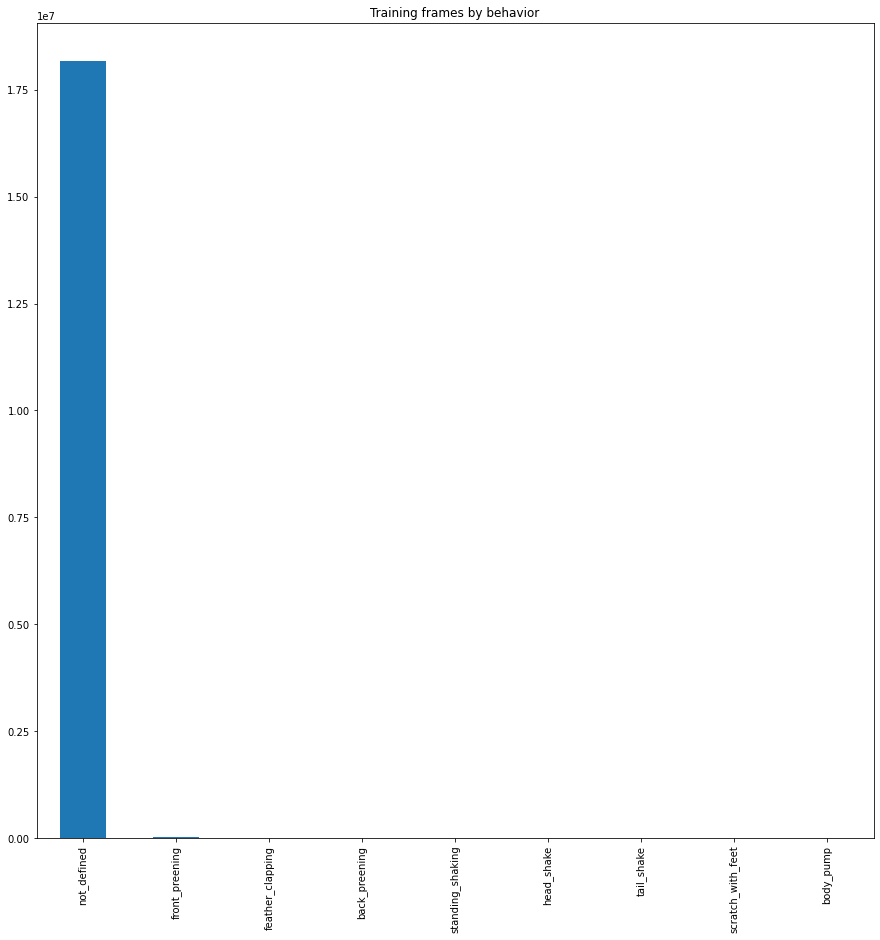

In [29]:
df.behavior.value_counts().plot(kind='bar', figsize=(15,15), title='Training frames by behavior')

There are videos we analyzed exhaustively, therefore, we now that behaviour that does not fall into the labelled categories can be considered a `base` behaviour.

<AxesSubplot:title={'center':'Training frames by behavior'}>

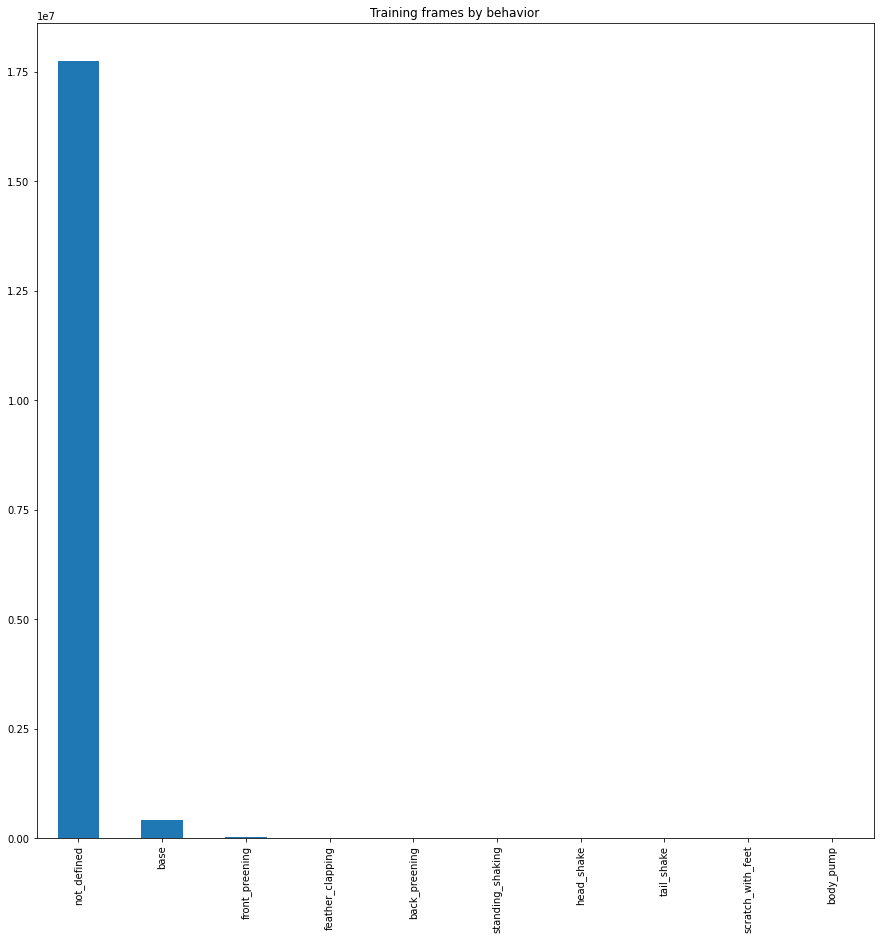

In [30]:
analyzed_files = [
    '233_monhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5',
    '877_1000ms_gopro_cut_day2DLC_resnet50_goprovrJul24shuffle1_1030000.h5',
    '239_control2_gopro_cut_day4DLC_resnet50_goprovrJul24shuffle1_1030000.h5',
    '251_monhab_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5',
    '889_control2_gopro_cut_day5DLC_resnet50_goprovrJul24shuffle1_1030000.h5'
    '418_100ms_gopro_cut_day5DLC_resnet50_goprovrJul24shuffle1_1030000.h5',
    '876_1000ms_gopro_cut_day1DLC_resnet50_goprovrJul24shuffle1_1030000.h5',
    '239_1000ms_gopro_cut_day3DLC_resnet50_goprovrJul24shuffle1_1030000.h5',
]

df.loc[(df['behavior'] == 'not_defined') & (df['file_name'].isin(analyzed_files)), ['behavior']] = 'base'
df.behavior.value_counts().plot(kind='bar', figsize=(15,15), title='Training frames by behavior')

In [31]:
df['lookback'] = df['behavior'].shift(2, fill_value="not_defined")
df['lookup'] = df['behavior'].shift(-1, fill_value="not_defined")

We drop all `not_defined` behaviours, since they dominate the data too much.

<AxesSubplot:title={'center':'Training frames by behavior'}>

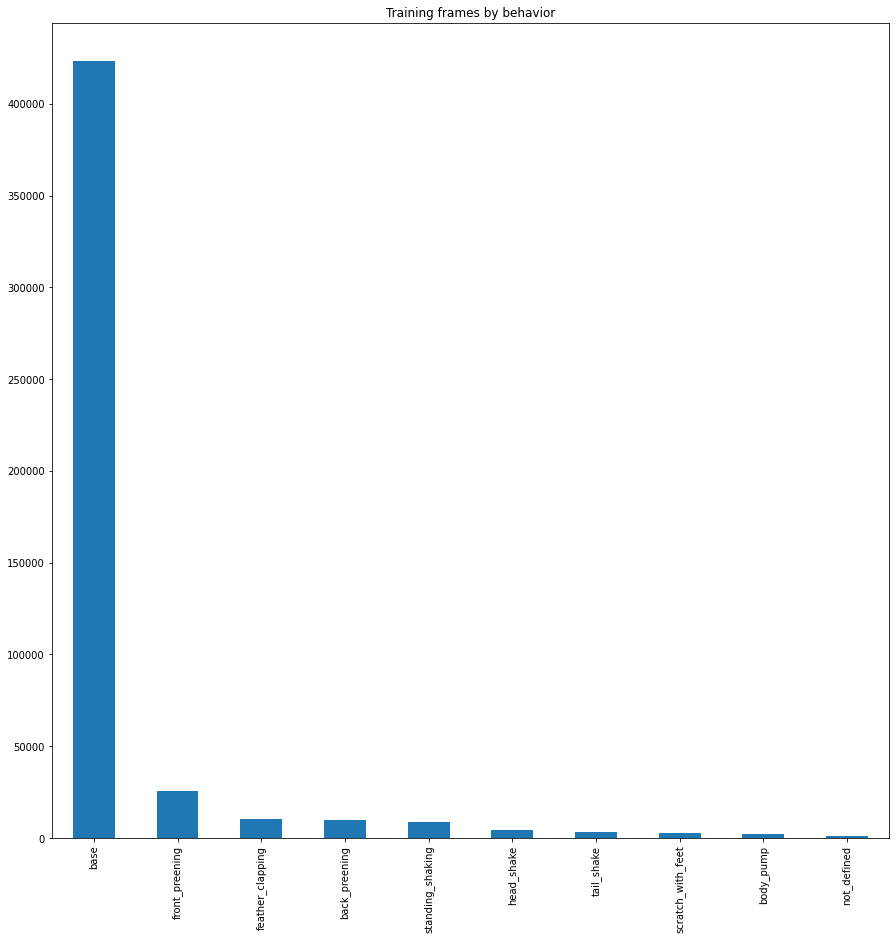

In [33]:
df = df[(df['behavior'] != "not_defined") | (df['lookback'] != "not_defined") | (df['lookup'] != "not_defined")]

df.behavior.value_counts().plot(kind='bar', figsize=(15,15), title='Training frames by behavior')

In [34]:
features = [('head', 'x'), ('head', 'y'), 
            ('tail', 'x'), ('tail', 'y'),  
            
            ('left_neck', 'x'), ('left_neck', 'y'), 
            ('right_neck', 'x'), ('right_neck', 'y'), 
            
            ('left_up_wing', 'x'), ('left_up_wing', 'y'),
            ('left_middle_wing', 'x'), ('left_middle_wing', 'y'),
            ('left_down_wing', 'x'), ('left_down_wing', 'y'),
            
            ('right_up_wing', 'x'), ('right_up_wing', 'y'),
            ('right_middle_wing', 'x'), ('right_middle_wing', 'y'),
            ('right_down_wing', 'x'), ('right_down_wing', 'y'),
]
timeslice_size = 8
segmented_timeseries, label_vector, label_names = ml.build_timeseries(df, features, timeslice_size)

  0%|          | 0/491115 [00:00<?, ?it/s]

In [35]:
np.save("segments-8.npy", segmented_timeseries)
np.save("label-8.npy", label_vector)
np.save("label-names-8.npy", label_names)

In [37]:
decoded_y = np.argmax(label_vector, axis=1)
pd.Series(decoded_y).value_counts()

1    423074
4     25744
3     10265
0     10001
7      8622
5      4414
8      3455
6      2957
2      2463
dtype: int64

In [38]:
label_names

['back_preening',
 'base',
 'body_pump',
 'feather_clapping',
 'front_preening',
 'head_shake',
 'scratch_with_feet',
 'standing_shaking',
 'tail_shake']

Epoch 1/500
288/288 [==============================] - 5s 15ms/step - loss: 0.6011 - categorical_accuracy: 0.8419
Epoch 2/500
288/288 [==============================] - 3s 11ms/step - loss: 0.2632 - categorical_accuracy: 0.9215
Epoch 3/500
288/288 [==============================] - 3s 11ms/step - loss: 0.1998 - categorical_accuracy: 0.9393
Epoch 4/500
288/288 [==============================] - 3s 11ms/step - loss: 0.1671 - categorical_accuracy: 0.9486
Epoch 5/500
288/288 [==============================] - 3s 11ms/step - loss: 0.1432 - categorical_accuracy: 0.9549
Epoch 6/500
288/288 [==============================] - 3s 10ms/step - loss: 0.1314 - categorical_accuracy: 0.9589
Epoch 7/500
288/288 [==============================] - 3s 10ms/step - loss: 0.1249 - categorical_accuracy: 0.9614
Epoch 8/500
288/288 [==============================] - 3s 11ms/step - loss: 0.1103 - categorical_accuracy: 0.9653
Epoch 9/500
288/288 [==============================] - 3s 10ms/step - loss: 0.1056 - cat

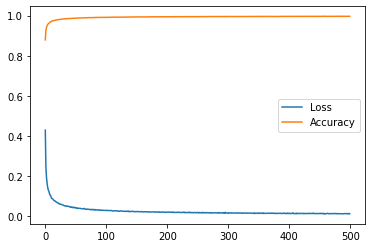

In [40]:
x_train, x_test, y_train, y_test = train_test_split(segmented_timeseries, label_vector, test_size=0.4, stratify=label_vector)
model = ml.build_model(x_train, label_vector)
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
hist = model.fit(x_train,
            y_train,
            batch_size=1024,
            epochs=500,
            verbose=1, callbacks=[tensorboard_callback])
    
plt.plot(hist.history['loss'], label="Loss")
plt.plot(hist.history['categorical_accuracy'], label="Accuracy")
plt.legend()
plt.show()


768/768 [==============================] - 3s 4ms/step - loss: 0.0521 - categorical_accuracy: 0.9930


'test loss: 0.05212167650461197\ttest accuracy: 0.9930396676063538'

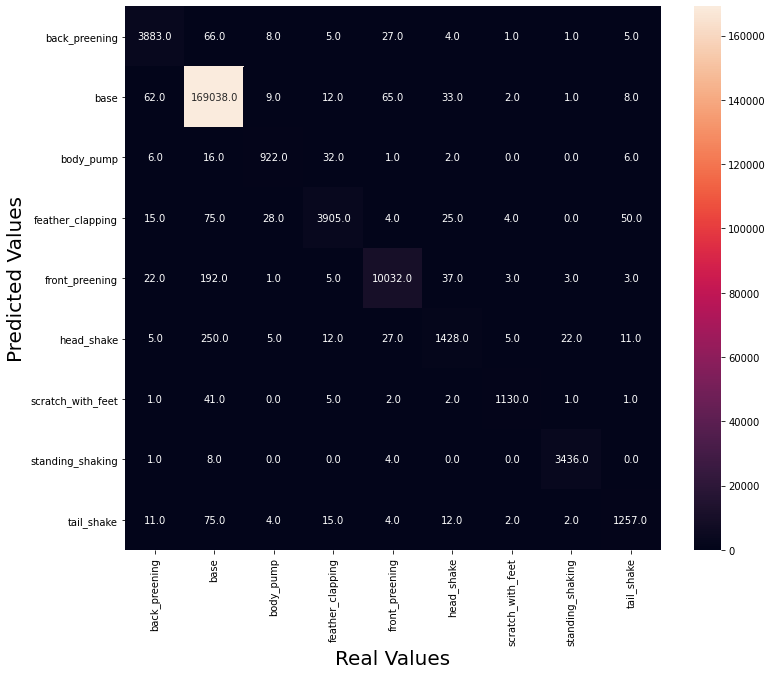

In [41]:

results = model.evaluate(x_test, y_test, batch_size=256)
display(f"test loss: {results[0]}\ttest accuracy: {results[1]}")


# getting predicted values for test data
y_pred = model.predict(x_test)

# matching true labels to predicted output
y_true=np.argmax(y_test, axis=1)
confusion = confusion_matrix(y_true, np.argmax(y_pred, axis=1))

df_cm = pd.DataFrame(confusion)
plt.figure(figsize = (12,10))

sn.heatmap(df_cm, annot=True, fmt=".1f", xticklabels=label_names, yticklabels=label_names)
plt.xlabel("Real Values", fontsize=20)
plt.ylabel("Predicted Values", fontsize=20)
plt.show()

In [43]:
model.save("model_8s-500e-1024b-0015L-nosampling-sliding")

INFO:tensorflow:Assets written to: model_8s-500e-1024b-0015L-nosampling-sliding\assets


## Run against real video

In [77]:
import datetime
import re
import tensorflow_addons as tfa
from tensorflow import keras
from winkie import dlc_importer

model_name = "model_8s-500e-1024b-0015L-nosampling-sliding"
video_file = '239_control2_gopro_cut_day4DLC_resnet50_goprovrJul24shuffle1_1030000.h5'
expected_labels = 'completely_labelled_239_control2_gopro_cut_day4.txt'

In [78]:
def build_timeseries_for_prediction(df, features, timeslice_length):

    segments = []

    for i in range(0, len(df) - timeslice_length + 1):
        s = []
        i_end = i + timeslice_length
        for f in features:
            s.append(df[f[0], f[1]].values[i:i_end])
            
        segments.append(s)

    return np.asarray(segments).reshape(-1, timeslice_length, len(features))

In [85]:
p = re.compile(r'(^[A-Za-z_]*) *= *(?:slice)? ?\((\d*), ?(\d*)\)')
behaviours = []
with open(expected_labels) as f:
  for x in f:
    m = p.match(x)
    frames = int(m.group(3)) - int(m.group(2))
    b = m.group(1)
    behaviours += frames * [b]
expected = pd.Series(behaviours)

model = keras.models.load_model(model_name)

imp = dlc_importer.DLCImporter()
df_analyze = imp.import_hdf(video_file)
df_analyze['expected'] = expected


timeslice = 8
segments = build_timeseries_for_prediction(df_analyze, features, timeslice)

predictions = model.predict(segments)

classes = pd.Series(np.argmax(predictions, axis = 1))
confidence = pd.Series(np.max(predictions, axis = 1))

label_mapping = label_names

df_analyze['class'] = classes
df_analyze['class'] = df_analyze['class'].replace(np.NaN, 1.0)
df_analyze['b'] = df_analyze.apply(lambda row: label_mapping[int(row['class'])], axis=1)

df_analyze['confidence'] = confidence

df_anomalies = df_analyze[(df_analyze['class'] != 1.0) & (df_analyze['class'] != -1.0)]
df_anomalies.groupby((df_anomalies['class'].shift() != df_anomalies['class']).cumsum())

recall = []

for k, v in df_anomalies.groupby((df_anomalies['class'].shift() != df_anomalies['class']).cumsum()):
    recall.append([
        v['b'].head(1).values[0], 
        v['expected'].unique(), 
        v['expected'].head(1).values[0],
        datetime.timedelta(seconds=v.head(1).index.values[0] / 119.88),
        len(v), 
        v.head(1).index.values[0],
        v.tail(1).index.values[0]])

expected_class_lookup = {
    'eating': 1.0,
    'standing': 1.0,
    'hp': 5.0,
    'walking': 1.0,
    'fp': 4.0,
    'sf': 6.0,
    'bp': 2.0,
    'eating_flor': 1.0,
    'backp': 0.0,
    np.NAN: 1.0
}

    
df_performance = pd.DataFrame(recall, columns=['detected', 'expected', 'confidence', 'time', 'length', 'start', 'end'])
df_analyze['expected_class'] = df_analyze.apply(lambda row: expected_class_lookup[row['expected'][0]], axis=1)

<AxesSubplot:>

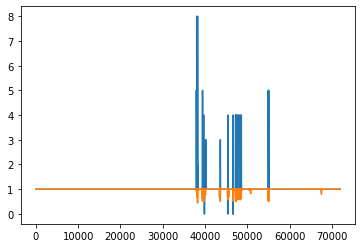

In [86]:
df_analyze['class'].plot()
df_analyze['confidence'].plot()

In [87]:
def calc_accuracy(df):
    ytrue = df['expected_class']
    ypred = df['class']

    metric = tf.keras.metrics.Accuracy()
    metric.update_state(ytrue, ypred)
    print(metric.result().numpy())

def calc_f1(df, pred):
    ytrue = encode_true(df)
    metric = tfa.metrics.F1Score(num_classes=len(ytrue[0]), threshold=None)
    metric.update_state(ytrue[:-7], pred)
    print(metric.result().numpy())
    
def calc_cat_accuracy(df, pred):
    ytrue = encode_true(df)
    print(len(ytrue))
    metric = tf.keras.metrics.CategoricalAccuracy()
    metric.update_state(ytrue[:-7], pred)
    print(metric.result().numpy())

def encode_true(df):
    ytrue = []
    for i, v in df['expected_class'].items():
        exp = [0] * 9
        exp[int(v)] = 1
        ytrue.append(exp)
    return ytrue

calc_accuracy(df_analyze)

print(len(predictions))
print(len(df_analyze))

calc_cat_accuracy(df_analyze, predictions)
calc_f1(df_analyze, predictions)
print(label_names)

0.9841367
71920
71927
71927
0.98413515
[0.34925866 0.9919192  0.         0.         0.6940097  0.01190476
 0.         0.         0.        ]
['back_preening', 'base', 'body_pump', 'feather_clapping', 'front_preening', 'head_shake', 'scratch_with_feet', 'standing_shaking', 'tail_shake']


## Debugging splitting of train and test data

Since we have the feeling that labels might be wrong, we want to investigate the data distribution in training and test set.

In [44]:
def count_labels(encoded_data, label_names):
    label_counts = { i : 0 for i in label_names }
    for i in range(encoded_data.shape[0]):
        index = np.argmax(encoded_data[i])
        label = label_names[index]
        label_counts[label] = label_counts[label] + 1

    return pd.DataFrame([label_counts])

,back_preening,base,body_pump,feather_clapping,front_preening,head_shake,scratch_with_feet,standing_shaking,tail_shake
0,6001,253844,1478,6159,15446,2649,1774,5173,2073


,back_preening,base,body_pump,feather_clapping,front_preening,head_shake,scratch_with_feet,standing_shaking,tail_shake
0,4000,169230,985,4106,10298,1765,1183,3449,1382


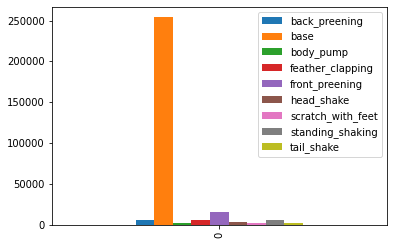

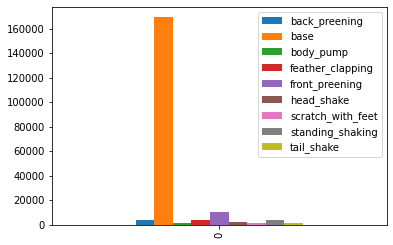

In [46]:
df_train = count_labels(y_train, label_names)
df_test = count_labels(y_test, label_names)

for d in [df_train, df_test]:
    display(d)
    d.plot.bar()